# Example: convert DHARMA LES 2D output to DEPHY format

Code to read DHARMA LES output files and write to DEPHY format (NetCDF)

Contributed by Florian Tornow Columbia University & NASA/GISS and Ann Fridlind from NASA/GISS

## Import libraries

In [3]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import os
import netCDF4
import datetime as dt
from netCDF4 import Dataset
import re
import sys

import pathlib

%run function_extract_2d.py 

## Specify directory locations

If on the ARM JupyterHub, it is recommended to create and specify a local directory that is outside of the COMBLE-MIP repository to upload raw model output files in your model's format. 

Processed domain-mean outputs are invited for commit to the GitHub repository on a user-specified branch under /comble-mip/output_les/YOUR_MODEL_NAME/sandbox/YOUR_RUN_NAME. These can be committed and removed at any time.

It is requested to name your baseline small-domain run directory as 'Lx25km_dx100m' (in place of YOUR_RUN_NAME), so that it can readily be automatically compared with other runs using the same test specification.

In [11]:
# specify start time of simulation and simulation name
start_dtime = '2020-03-12 22:00:00.0'

# specify input data directory name, traceable to source machine, and
# specify output file name (see file naming convention in TOC)

# ProgNa with ice test
my_readdir = 'case0313_diag_ice25_nomiz_dx100_specZ0_hm_largedomain'
my_outfile = 'DHARMA_Lx25_dx100_FixN_2D_large.nc'

# FixN with no ice test
my_readdir = 'case0313_diag_ice0_nomiz_dx100_specZ0'
my_outfile = 'DHARMA_Lx25_dx100_FixN_noice_2D.nc'

# specify local source directories (additional subdirectories if restart was required)
my_rundir = '/data/home/floriantornow/dharma/sandbox/' + my_readdir + '/'

my_outdirs = sorted([f for f in os.listdir(my_rundir) if not f.startswith('.')], key=str.lower)
print(my_outdirs)

# specify Github scratch directory where processed model output will be committed
my_gitdir = '../../output_les/dharma/sandbox/'

['0-20h']


## Read DHARMA data

### Locate 2D files

In [6]:
## locate all files that have the expected filename (*.tgz)
path = my_rundir + my_outdirs[0]
direc = pathlib.Path(path)
NCFILES = list(direc.rglob("*tgz"))
NCFILES_STR = [str(p) for p in pathlib.Path(path).rglob('*.tgz')]

print(NCFILES_STR)

input_filenames = []
count = 0
for fn in NCFILES: 
    if ('alt_0' in NCFILES_STR[count]):
        input_filenames.append(fn)
    count += 1
    
input_filenames = sorted(input_filenames)

['/data/home/floriantornow/dharma/sandbox/case0313_diag_ice0_nomiz_dx100_specZ0/0-20h/dharma_alt_021984.tgz', '/data/home/floriantornow/dharma/sandbox/case0313_diag_ice0_nomiz_dx100_specZ0/0-20h/dharma_alt_010091.tgz', '/data/home/floriantornow/dharma/sandbox/case0313_diag_ice0_nomiz_dx100_specZ0/0-20h/dharma_alt_007202.tgz', '/data/home/floriantornow/dharma/sandbox/case0313_diag_ice0_nomiz_dx100_specZ0/0-20h/dharma_alt_001440.tgz', '/data/home/floriantornow/dharma/sandbox/case0313_diag_ice0_nomiz_dx100_specZ0/0-20h/dharma_alt_018909.tgz', '/data/home/floriantornow/dharma/sandbox/case0313_diag_ice0_nomiz_dx100_specZ0/0-20h/dharma_alt_028317.tgz', '/data/home/floriantornow/dharma/sandbox/case0313_diag_ice0_nomiz_dx100_specZ0/0-20h/dharma_alt_011548.tgz', '/data/home/floriantornow/dharma/sandbox/case0313_diag_ice0_nomiz_dx100_specZ0/0-20h/dharma_alt_017385.tgz', '/data/home/floriantornow/dharma/sandbox/case0313_diag_ice0_nomiz_dx100_specZ0/0-20h/dharma_alt_3d_029815.tgz', '/data/home/flo

### Read 2D files

In [7]:
## obtain model horizontal resolution
input_filename = my_rundir + my_outdirs[0] + '/dharma.cdf'
dharma_params = xr.open_dataset(input_filename)
print(input_filename)

nx = dharma_params['geometry'].nx
Lx = dharma_params['geometry'].L_x

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


/data/home/floriantornow/dharma/sandbox/case0313_diag_ice0_nomiz_dx100_specZ0/0-20h/dharma.cdf


In [8]:
xy_res = Lx/nx
xy_res

100.0

In [10]:

%run function_extract_2d.py 
time_vec = []

counter = 0
for input_filename in input_filenames:
    
    ## obtain timestamp
    time_vec.append(obtain_time(path,input_filename))

    ## ascertain horizontal resolution and prepare horizontal grid
    xy_res = Lx/nx
    x_vec = np.arange(-Lx/2, Lx/2, xy_res)
    y_vec = np.arange(-Lx/2, Lx/2, xy_res)
        
    ## unpack tgz and extract relevant fields 
    opd_cloud = read_2d(FILE=input_filename,vbase = 'opd_drops',retain=True)
    opd_ice   = read_2d(FILE=input_filename,vbase = 'opd_ice',retain=True,there=True)
    alb       = (opd_cloud + opd_ice)/(13 + opd_cloud + opd_ice)
    opd       = opd_cloud + opd_ice
    
    lwp       = read_2d(FILE=input_filename,vbase = 'lwp',retain=True,there=True)/1000
    iwp       = read_2d(FILE=input_filename,vbase = 'iwp',retain=True,there=True)/1000
    pflux     = read_2d(FILE=input_filename,vbase = 'pflux',retain=True,there=True)
    sfcTflx   = read_2d(FILE=input_filename,vbase = 'sfc_T_flx',retain=True,there=True)
    sfcQflx   = read_2d(FILE=input_filename,vbase = 'sfc_qv_flx',retain=True,there=True)
    u10m      = read_2d(FILE=input_filename,vbase = 'u_layer1',retain=True,there=True) + dharma_params['translate'].u
    v10m      = read_2d(FILE=input_filename,vbase = 'v_layer1',retain=True,there=True) + dharma_params['translate'].v
    LWup      = read_2d(FILE=input_filename,vbase = 'Fup_toa_10um',there=True)
    
    ## accumulate
    if counter == 0:
        sfcTflx_col = sfcTflx
        sfcQflx_col = sfcQflx
        u10m_col    = u10m
        v10m_col    = v10m
        pflux_col   = pflux
        lwp_col     = lwp
        iwp_col     = iwp
        alb_col     = alb
        opd_col     = opd
        LWup_col    = LWup
    else:
        sfcTflx_col = np.append(sfcTflx_col,sfcTflx,axis=0)
        sfcQflx_col = np.append(sfcQflx_col,sfcQflx,axis=0)
        u10m_col    = np.append(u10m_col,u10m,axis=0)
        v10m_col    = np.append(v10m_col,v10m,axis=0)
        pflux_col   = np.append(pflux_col,pflux,axis=0)
        lwp_col     = np.append(lwp_col,lwp,axis=0)
        iwp_col     = np.append(iwp_col,iwp,axis=0)
        alb_col     = np.append(alb_col,alb,axis=0)
        opd_col     = np.append(opd_col,opd,axis=0)
        LWup_col    = np.append(LWup_col,LWup,axis=0)
    
    counter += 1
 
    


|      0 |       0.0 |      0.0 | 0.0000E+00 | 0.0000E+00 | 0.3255 | 0.0000 |

|   1440 |    3600.0 |      0.4 | 0.2395E-07 | 0.4198E-08 | 0.3247 | 0.6000 |

|   2880 |    7200.0 |      0.4 | 0.2652E-07 | 0.4070E-08 | 0.3141 | 0.6000 |

|   4320 |   10800.0 |      0.4 | 0.2791E-07 | 0.3844E-08 | 0.4053 | 0.6000 |

|   5760 |   14400.0 |      0.5 | 0.3063E-07 | 0.3442E-08 | 0.5153 | 0.6000 |

|   7202 |   18000.0 |      0.5 | 0.3884E-07 | 0.2439E-08 | 0.1469 | 0.6000 |

|   8645 |   21600.0 |      0.5 | 0.3184E-07 | 0.2072E-08 | 0.2324 | 0.6000 |

|  10091 |   25200.0 |      0.5 | 0.3594E-07 | 0.1698E-08 | 0.3456 | 0.6000 |

|  11548 |   28800.0 |      0.5 | 0.2809E-07 | 0.1481E-08 | 0.0009 | 0.0562 |

|  13007 |   32400.0 |      0.5 | 0.3115E-07 | 0.1557E-08 | 0.2232 | 0.6000 |

|  14470 |   36000.0 |      0.5 | 0.3068E-07 | 0.1722E-08 | 0.0551 | 0.6000 |

|  15926 |   39600.0 |      0.5 | 0.2986E-07 | 0.1897E-08 | 0.1307 | 0.6000 |

|  17385 |   43200.0 |      0.5 | 0.3778E-07 | 0.216

In [12]:
## convert narrowband Flux (spectrally integrated) into Brightness Temperatureh = 6.62607015*(10**-34) ## J Hz-1
h = 6.62607015*(10**-34) ## J Hz-1
k = 1.380649*(10**-23)   ## J⋅K−1
c = 2.99*(10**8)         ## m s-1
lamb = 10.5*(10**-6) 


BT_col = h*c/(k*lamb*np.log(1 + (2*h*(c**2)/((LWup_col/2.12/np.pi)*(10**6)*(lamb**5)))))
    

## Prepare output file in DEPHY format

### Read requested variables list

Variable description, naming, units, and dimensions.

In [13]:
# read list of requested variables
vars_mean_list = pd.read_excel('https://docs.google.com/spreadsheets/d/1Vl8jYGviet7EtXZuQiitrx4NSkV1x27aJAhxxjBb9zI/export?gid=1756539842&format=xlsx',
                              sheet_name='2D')

pd.set_option('display.max_rows', None)
vars_mean_list

,standard_name,variable_id,units,dimensions,comment (10-min instantaneous)
0,time,time,s,–,"dimension, seconds since 2020-03-12 18:00:00"
1,x,x,m,–,"dimension, grid cell center"
2,y,y,m,–,"dimension, grid cell center"
3,surface_upward_sensible_heat_flux,hfss,W m-2,"time, x, y",–
4,surface_upward_latent_heat_flux,hfls,W m-2,"time, x, y",–
5,surface_friction_velocity,ustar,m s-1,"time, x, y",–
6,surface_eastward_wind,us,m s-1,"time, x, y",at 10-m for comparison with SAR satellite meas...
7,surface_northward_wind,vs,m s-1,"time, x, y",at 10-m for comparison with SAR satellite meas...
8,precipitation_flux_at_surface,pr,kg m-2 s-1,"time, x, y",all hydrometeors
9,atmosphere_mass_content_of_liquid_water,lwp,kg m-2,"time, x, y",all liquid hydrometeors


In [14]:
shape(alb_col)
shape(lwp_col)

(21, 256, 256)

In [15]:
# create DEPHY output file
dephy_filename = './' + my_gitdir + my_outfile
if os.path.exists(dephy_filename):
    os.remove(dephy_filename)
    print('The file ' + dephy_filename + ' has been deleted successfully')    
dephy_file = Dataset(dephy_filename,mode='w',format='NETCDF3_CLASSIC')

# create global attributes
dephy_file.title='DHARMA LES results for COMBLE-MIP case: fixed Nd and Ni'
dephy_file.reference='https://github.com/ARM-Development/comble-mip'
dephy_file.authors='Florian Tornow (florian.tornow@nasa.gov) and Ann Fridlind (ann.fridlind@nasa.gov)'
#dephy_file.source=input_filename
dephy_file.version=dt.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
dephy_file.format_version='DEPHY-derivative'
dephy_file.script='convert_DHARMA_LES_output_to_dephy_format_2D.ipynb'
dephy_file.startDate=start_dtime
dephy_file.force_geo=1
dephy_file.surfaceType='ocean (after spin-up)'
dephy_file.surfaceForcing='ts (after spin-up)'
#dephy_file.lat=str(dharma_params['Coriolis'].lat) + ' deg N'
#dephy_file.dx=str(dharma_params['geometry'].L_x/dharma_params['geometry'].nx) + ' m'
#dephy_file.dy=str(dharma_params['geometry'].L_y/dharma_params['geometry'].ny) + ' m'
#dephy_file.dz='see zf variable'
#dephy_file.nx=dharma_params['geometry'].nx
#dephy_file.ny=dharma_params['geometry'].ny
#dephy_file.nz=dharma_params['geometry'].nz

# create dimensions
xvec = dephy_file.createDimension('x', nx)
xvec = dephy_file.createVariable('x', np.float64, ('x',))
xvec.units = 'm'
xvec.long_name = 'x'
xvec[:] = x_vec

yvec = dephy_file.createDimension('y', nx)
yvec = dephy_file.createVariable('y', np.float64, ('y',))
yvec.units = 'm'
yvec.long_name = 'y'
yvec[:] = y_vec

nt = len(input_filenames)
time = dephy_file.createDimension('time', nt)
time = dephy_file.createVariable('time', np.float64, ('time',))
time.units = 'seconds since ' + dephy_file.startDate
time.long_name = 'time'
time[:] = time_vec[:]

# create and fill variables
for index in vars_mean_list.index[3:]:
    std_name = vars_mean_list.standard_name.iat[index]
    var_name = vars_mean_list['variable_id'].iat[index]
    #print(var_name)
    if (var_name == 'hfss') | (var_name == 'hfls'):
        continue
    if var_name == 'hfss':
        mod_field = sfcTflx_col
    if var_name == 'hfls':
        mod_field = sfcQflx_col
    if var_name == 'us':
        mod_field = u10m_col
    if var_name == 'vs':
        mod_field = v10m_col
    if var_name == 'pr':
        mod_field = pflux_col
    if var_name == 'lwp':
        mod_field = lwp_col
    if var_name == 'iwp':
        mod_field = iwp_col
    if var_name == 'opt':
        mod_field = opd_col
    if var_name == 'alb':
        mod_field = alb_col
    if var_name == 'olr11':
        mod_field = BT_col#LWup_col
    if var_name == 'ustar':
        continue
    
    if vars_mean_list.dimensions.iat[index]=='time, x, y':
        new_snd = dephy_file.createVariable(var_name, np.float64, ('time','x','y'))
        new_snd.units = vars_mean_list.units.iat[index]
        new_snd.long_name = std_name
        #if vars_mean_list.model_name.iat[index]!='missing data': #and mod_name in dharma_snds: 
        new_snd[:] = mod_field

print(dephy_file)
dephy_file.close()

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    title: DHARMA LES results for COMBLE-MIP case: fixed Nd and Ni
    reference: https://github.com/ARM-Development/comble-mip
    authors: Florian Tornow (florian.tornow@nasa.gov) and Ann Fridlind (ann.fridlind@nasa.gov)
    version: 2024-12-18 21:39:36
    format_version: DEPHY-derivative
    script: convert_DHARMA_LES_output_to_dephy_format_2D.ipynb
    startDate: 2020-03-12 22:00:00.0
    force_geo: 1
    surfaceType: ocean (after spin-up)
    surfaceForcing: ts (after spin-up)
    dimensions(sizes): x(256), y(256), time(21)
    variables(dimensions): float64 x(x), float64 y(y), float64 time(time), float64 us(time, x, y), float64 vs(time, x, y), float64 pr(time, x, y), float64 lwp(time, x, y), float64 iwp(time, x, y), float64 opt(time, x, y), float64 alb(time, x, y), float64 olr11(time, x, y)
    groups: 


In [16]:
dephy_check = xr.open_dataset(dephy_filename)
dephy_check

<xarray.Dataset> Size: 88MB
Dimensions:  (x: 256, y: 256, time: 21)
Coordinates:
  * x        (x) float64 2kB -1.28e+04 -1.27e+04 -1.26e+04 ... 1.26e+04 1.27e+04
  * y        (y) float64 2kB -1.28e+04 -1.27e+04 -1.26e+04 ... 1.26e+04 1.27e+04
  * time     (time) datetime64[ns] 168B 2020-03-12T22:00:00 ... 2020-03-13T18...
Data variables:
    us       (time, x, y) float64 11MB ...
    vs       (time, x, y) float64 11MB ...
    pr       (time, x, y) float64 11MB ...
    lwp      (time, x, y) float64 11MB ...
    iwp      (time, x, y) float64 11MB ...
    opt      (time, x, y) float64 11MB ...
    alb      (time, x, y) float64 11MB ...
    olr11    (time, x, y) float64 11MB ...
Attributes:
    title:           DHARMA LES results for COMBLE-MIP case: fixed Nd and Ni
    reference:       https://github.com/ARM-Development/comble-mip
    authors:         Florian Tornow (florian.tornow@nasa.gov) and Ann Fridlin...
    version:         2024-12-18 21:39:36
    format_version:  DEPHY-derivative
    script:          convert_DHARMA_LES_output_to_dephy_format_2D.ipynb
    startDate:       2020-03-12 22:00:00.0
    force_geo:       1
    surfaceType:     ocean (after spin-up)
    surfaceForcing:  ts (after spin-up)

In [17]:
dephy_filename

'./../../output_les/dharma/sandbox/DHARMA_Lx25_dx100_FixN_noice_2D.nc'

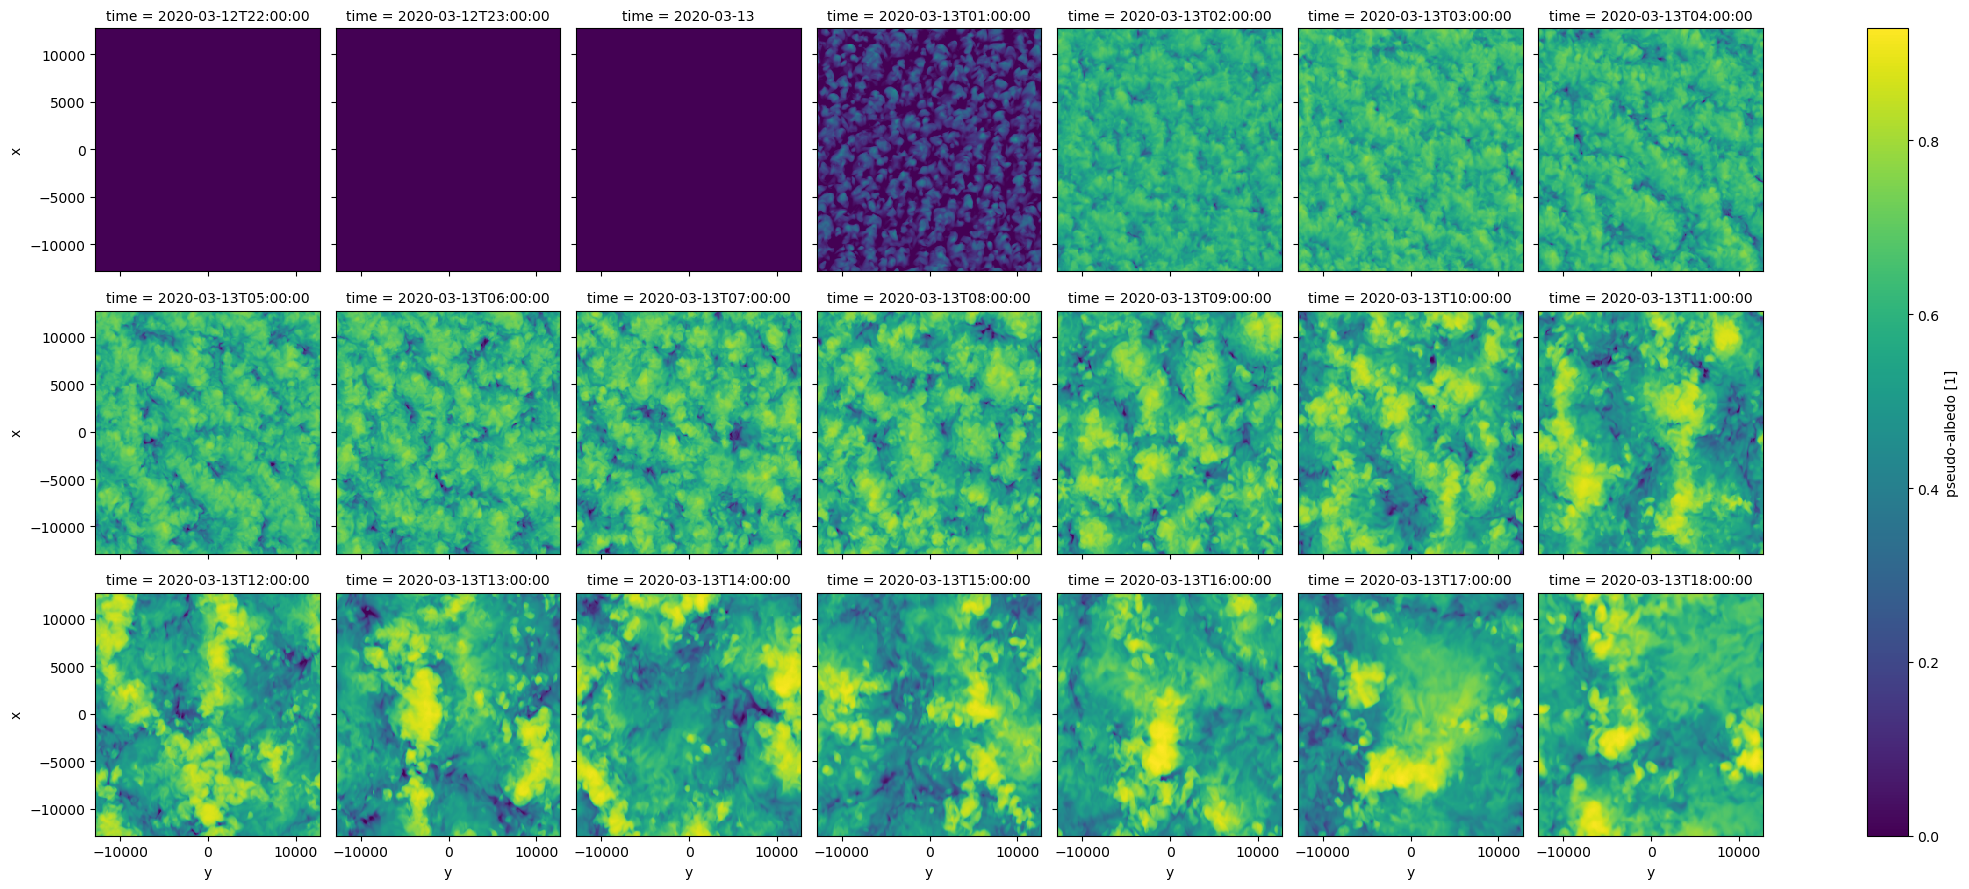

In [18]:
#dephy_check['olr11'].plot(row='time')
dephy_check['alb'].plot(row='time',col_wrap=7)